# Modelling
## Importing relevant libraries and csv

### Workflow

- Import in process dataset.
- Perform test/train split
- Perform StandardScaler for data sets
- Run through the models (filtering)
- Pick the model with the better adjusted R2
- Evaluate the coefficient w.r.t Features and picked the top 20
- Re-Train the model, identify the model with beteter adjusted R2
- Validate with holdout test data
- Submit for kaggle
- Provide recommendation

In [1]:
# import libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from pandas_profiling import ProfileReport as pp
import seaborn as sns
import scipy.stats as stats


sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, LassoCV, RidgeCV,Ridge

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error
# import warnings
# warnings.filterwarnings(action='once')




This is based on assumption that our baseline score is based on the average of saleprice and benchmarking our model against it.

In [2]:
#re-import the dataset
train = pd.read_csv('../datasets/train_processed.csv')

test = pd.read_csv('../datasets/test_processed.csv')

In [3]:
# check the shape of datasets
print(train.shape)
print(test.shape)


(2047, 181)
(879, 180)


***Function for adjusted R2***

In [4]:
#function for adjusted R2
def r2_adj(y_true, y_preds, p):
    n = len(y_true)
    y_mean = np.mean(y_true)
    numerator = np.sum(np.square(y_true - y_preds)) / (n - p - 1)
    denominator = np.sum(np.square(y_true - y_mean)) / (n - 1)
    return 1 - numerator / denominator

***Function for metrics***

In [5]:
#function to print the metrics required
def print_metrics(y_true, y_pred, p):
    mse = mean_squared_error(y_true, y_pred)

    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    r2a = r2_adj(y_true, y_pred, p)
    
    print('Root mean squared error = ', rmse)
    print('R^2                     = ', r2)
    print('Adjusted R^2            = ', r2a)

In [6]:
#ID and saleprice is not required in the features
#drop them first
features=train.columns.drop(['saleprice','id'])
X=train[features]
y=train['saleprice']

##### Train/Test Split

In [7]:
# perform train and test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=15)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1637, 179), (410, 179), (1637,), (410,))

#### Standard Scaler

In [8]:
#perform standard scaler 
ss= StandardScaler()
X_train_scaled=ss.fit_transform(X_train)
X_test_scaled=ss.transform(X_test)

### Exploring Linear Regression 

In [9]:
#Linear Regression Fitting
lr=LinearRegression()
linreg_scores=cross_val_score(lr, X_train_scaled, y_train, cv=10)
lr.fit(X_train_scaled, y_train)
r2_score_ling=np.mean(linreg_scores)


In [10]:
print('---Linear Regression---')
print('R2 score:{}'.format(r2_score_ling))

---Linear Regression---
R2 score:-4.377466946216419e+19


 The mean R^2 is extremely negative.
 The linear regression is probably dramatically overfitting and the redundant variables are affecting the coefficients in weird ways.
 We will proceed on to carry out modelling on Ridge and Lasso Regression Models.

***Function for saving file for submission***

In [11]:
#this function gerenrate csv with prediction scores 
def sub_df(predict,filepath):
    df=pd.DataFrame(test['id'])
    df['saleprice']=predict
    df.set_index(['id'],inplace=True)
    df.to_csv(filepath)

### Exploring Lasso Regression

In [12]:
# to find the optimal alpha
lasso_find=LassoCV(n_alphas=300)
lasso_find.fit(X_train_scaled,y_train)
lasso=Lasso(alpha=lasso_find.alpha_,tol=0.1)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [13]:
# get coefficient and get the metrics
score= cross_val_score(lasso,X_train_scaled,y_train,cv=10)
lasso.fit(X_train_scaled,y_train)
pred_lasso=lasso.predict(X_test_scaled)

In [14]:
#get metrics
print('---Lasso Metrics---')
print_metrics(y_test,pred_lasso,X.shape[1])

---Lasso Metrics---
Root mean squared error =  26453.620443281423
R^2                     =  0.8830015715950751
Adjusted R^2            =  0.7919462729668943


### Exploring Ridge Regression

In [15]:
#find optimal alpha
ridge_find=RidgeCV(alphas=np.logspace(0,5,200),store_cv_values=True)
ridge_find.fit(X_train_scaled,y_train)
ridge=Ridge(alpha=ridge_find.alpha_)

In [16]:
#train the model and get coefficient 
score2=cross_val_score(ridge,X_train_scaled,y_train,cv=10)
ridge.fit(X_train_scaled,y_train)
pred_ridge=ridge.predict(X_test_scaled)
r2score_ridge=r2_score(y_test,pred_ridge)
rmse_ridge=np.sqrt(mean_squared_error(y_test,pred_ridge))

In [17]:
# get metrics
print('---Ridge Metrics---')
print_metrics(y_test,pred_ridge,X.shape[1])

---Ridge Metrics---
Root mean squared error =  26144.07074830242
R^2                     =  0.8857236890065557
Adjusted R^2            =  0.7967869078420926


Referencing the adjusted R^2 for the three model, I have selected the model with highest adjusted R^2 and narrowing features from the model.

### Filter Selection to identify features to use in final model
#### Top 20 features based on the highest adjusted R2 model

In [18]:
ridge_coeff=dict(zip(features,ridge.coef_))

In [19]:
df_ridge_coeff=pd.DataFrame(list(ridge_coeff.items()),columns=['features','coefficient'])

In [20]:
df_ridge_coeff['abs_coefficient']=abs(df_ridge_coeff['coefficient'])

In [21]:
#assign top 20 features to new variable
feature_for_model2=df_ridge_coeff.sort_values('abs_coefficient',ascending=False).head(20)['features'].tolist()

In [22]:
#print them and preview
df_ridge_coeff.sort_values('abs_coefficient',ascending=False).head(20)

,features,coefficient,abs_coefficient
22,gr_liv_area,12238.820523,12238.820523
32,total_sf,10430.062498,10430.062498
4,overall_qual,9883.549132,9883.549132
14,bsmtfin_sf_1,7365.789647,7365.789647
82,neighborhood_NridgHt,7142.794793,7142.794793
1,lot_area,6729.989421,6729.989421
8,exter_qual,5675.827043,5675.827043
88,neighborhood_StoneBr,5661.767532,5661.767532
25,kitchen_qual,5564.550609,5564.550609
6,year_built,5413.763822,5413.763822


In [23]:
print(feature_for_model2)

['gr_liv_area', 'total_sf', 'overall_qual', 'bsmtfin_sf_1', 'neighborhood_NridgHt', 'lot_area', 'exter_qual', 'neighborhood_StoneBr', 'kitchen_qual', 'year_built', 'total_bsmt_sf', 'bsmt_exposure', 'overall_cond', '1st_flr_sf', 'sale_type_New', 'exterior_1st_BrkFace', 'neighborhood_NoRidge', 'totrms_abvgrd', 'bldg_type_TwnhsE', 'bsmt_cond']


In [24]:
# train the final model with the top 20 features
X2=train[feature_for_model2]
y2=train['saleprice']

In [25]:
X_train2,X_test2,y_train2,y_test2=train_test_split(X2,y2,test_size=0.2,random_state=15)
print(X_train2.shape,X_test2.shape,y_train2.shape,y_test2.shape)

(1637, 20) (410, 20) (1637,) (410,)


In [26]:
ss=StandardScaler()
X_train2_scale=ss.fit_transform(X_train2)
X_test2_scale=ss.transform(X_test2)



#### Re-model with newly selected features

In [27]:
#lasso method model refitting
#search for optimal cv
lasso_search=LassoCV(n_alphas=300)
lasso_search.fit(X_train2_scale,y_train2)
lasso2=Lasso(alpha=lasso_search.alpha_, tol=0.1)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [28]:
#train model
score= cross_val_score(lasso2,X_train2_scale,y_train2,cv=10)
lasso2.fit(X_train2_scale,y_train2)
pred_lasso2=lasso2.predict(X_test2_scale)
#r2score_lasso_new=r2_score(y_test2,pred)
#rmse_lasso_new=np.sqrt(mean_squared_error(y_test,pred))

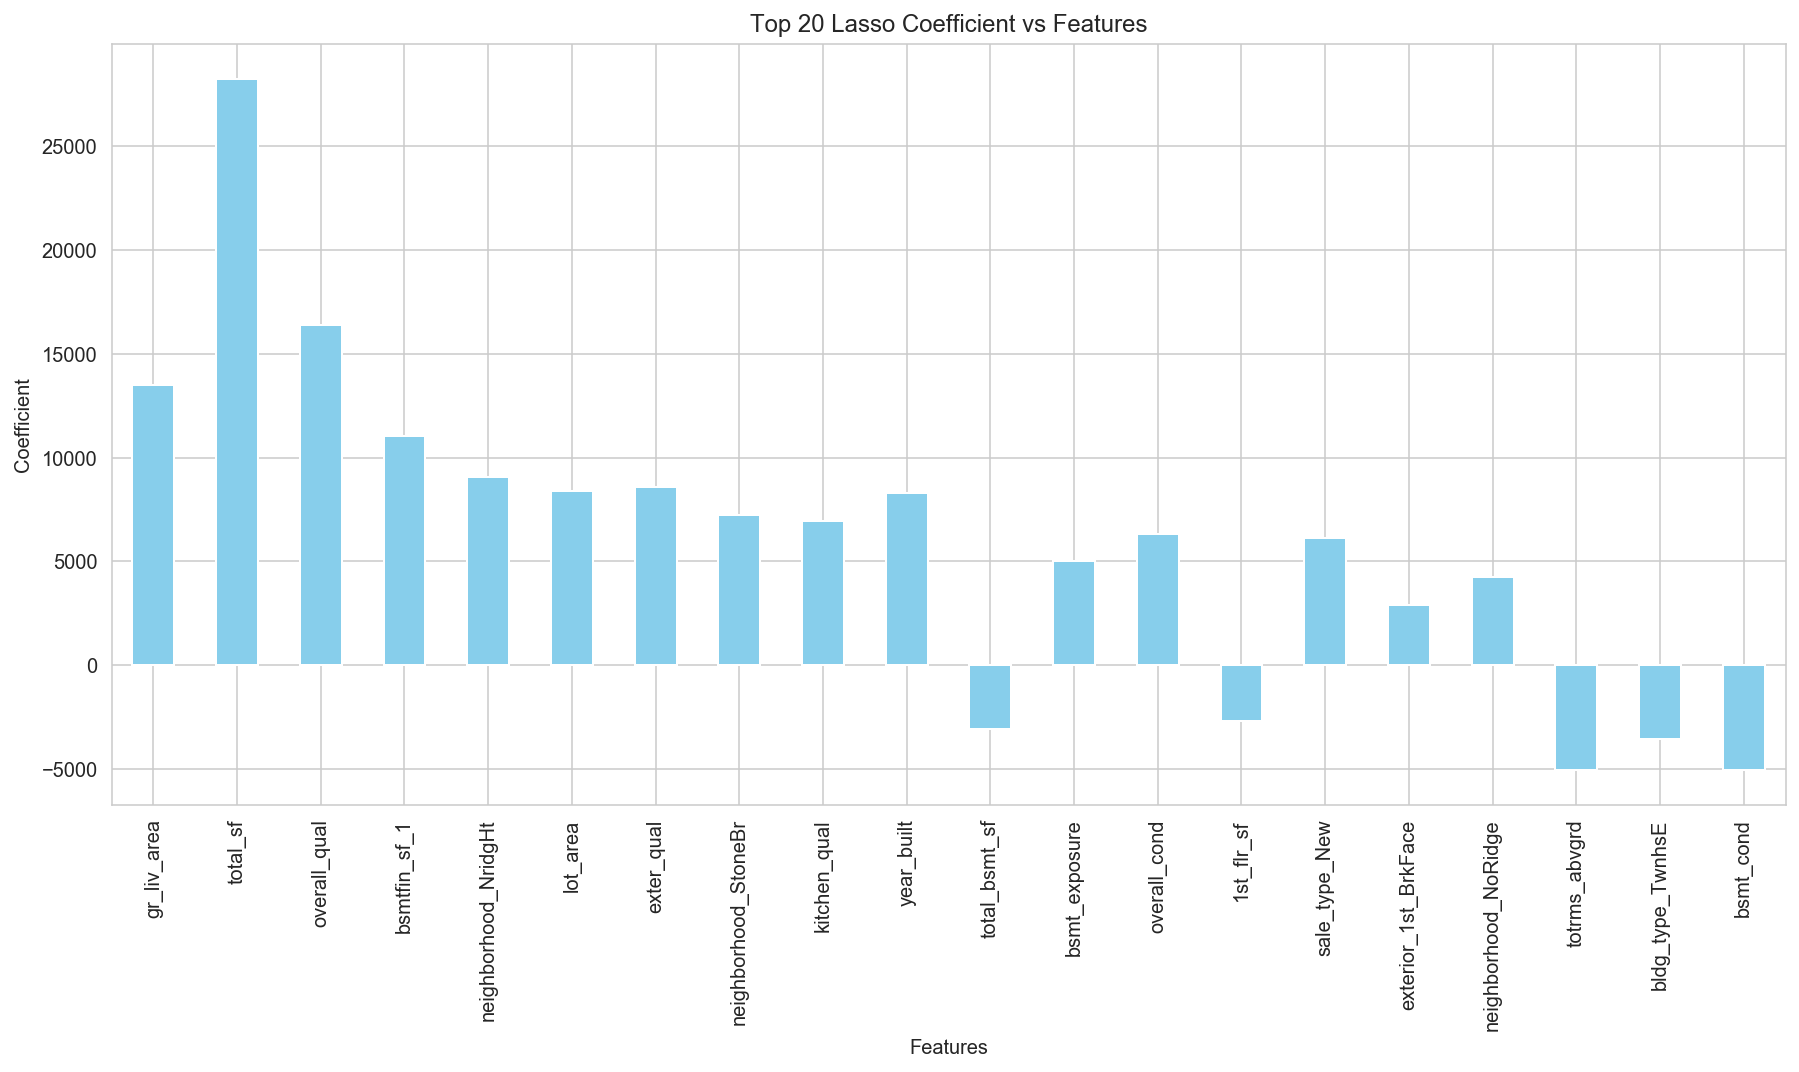

In [29]:
#visualising the coefficient
pd.Series(lasso2.coef_, index= feature_for_model2).plot.bar(figsize=(15,7), color='skyblue')
plt.title('Top 20 Lasso Coefficient vs Features')
plt.xlabel('Features')
plt.ylabel('Coefficient');

>This is a visualisation of Lasso coefficient. For every unit of increase/ decrease of the respective features, the corresponding y represents the amount of unit which we will see in increase and decrease in. For e.g. total_sf. For every increase in unit for total_sf, we will see approximately 28000 unit of increment sigificant level to sale price. 

In [30]:
print('---Lasso ReModel---')
print_metrics(y_test2,pred_lasso2,X.shape[1])

---Lasso ReModel---
Root mean squared error =  29009.758038459237
R^2                     =  0.8592987340184035
Adjusted R^2            =  0.7497964444066393


In [31]:
#ridge model 
# get optimal cv
ridge_search=RidgeCV(alphas=np.logspace(0,5,200),store_cv_values=True)
ridge_search.fit(X_train2_scale,y_train2)

ridge2=Ridge(alpha=ridge_search.alpha_)

In [32]:
# train model
score2=cross_val_score(ridge2,X_train2_scale,y_train2,cv=10)
ridge2.fit(X_train2_scale,y_train2)

pred_ridge2= ridge2.predict(X_test2_scale)
# r2_score_new_ridge=r2_score(y_test,pred)
# rmse_new_ridge=np.sqrt(mean_squared_error(y_test,pred))

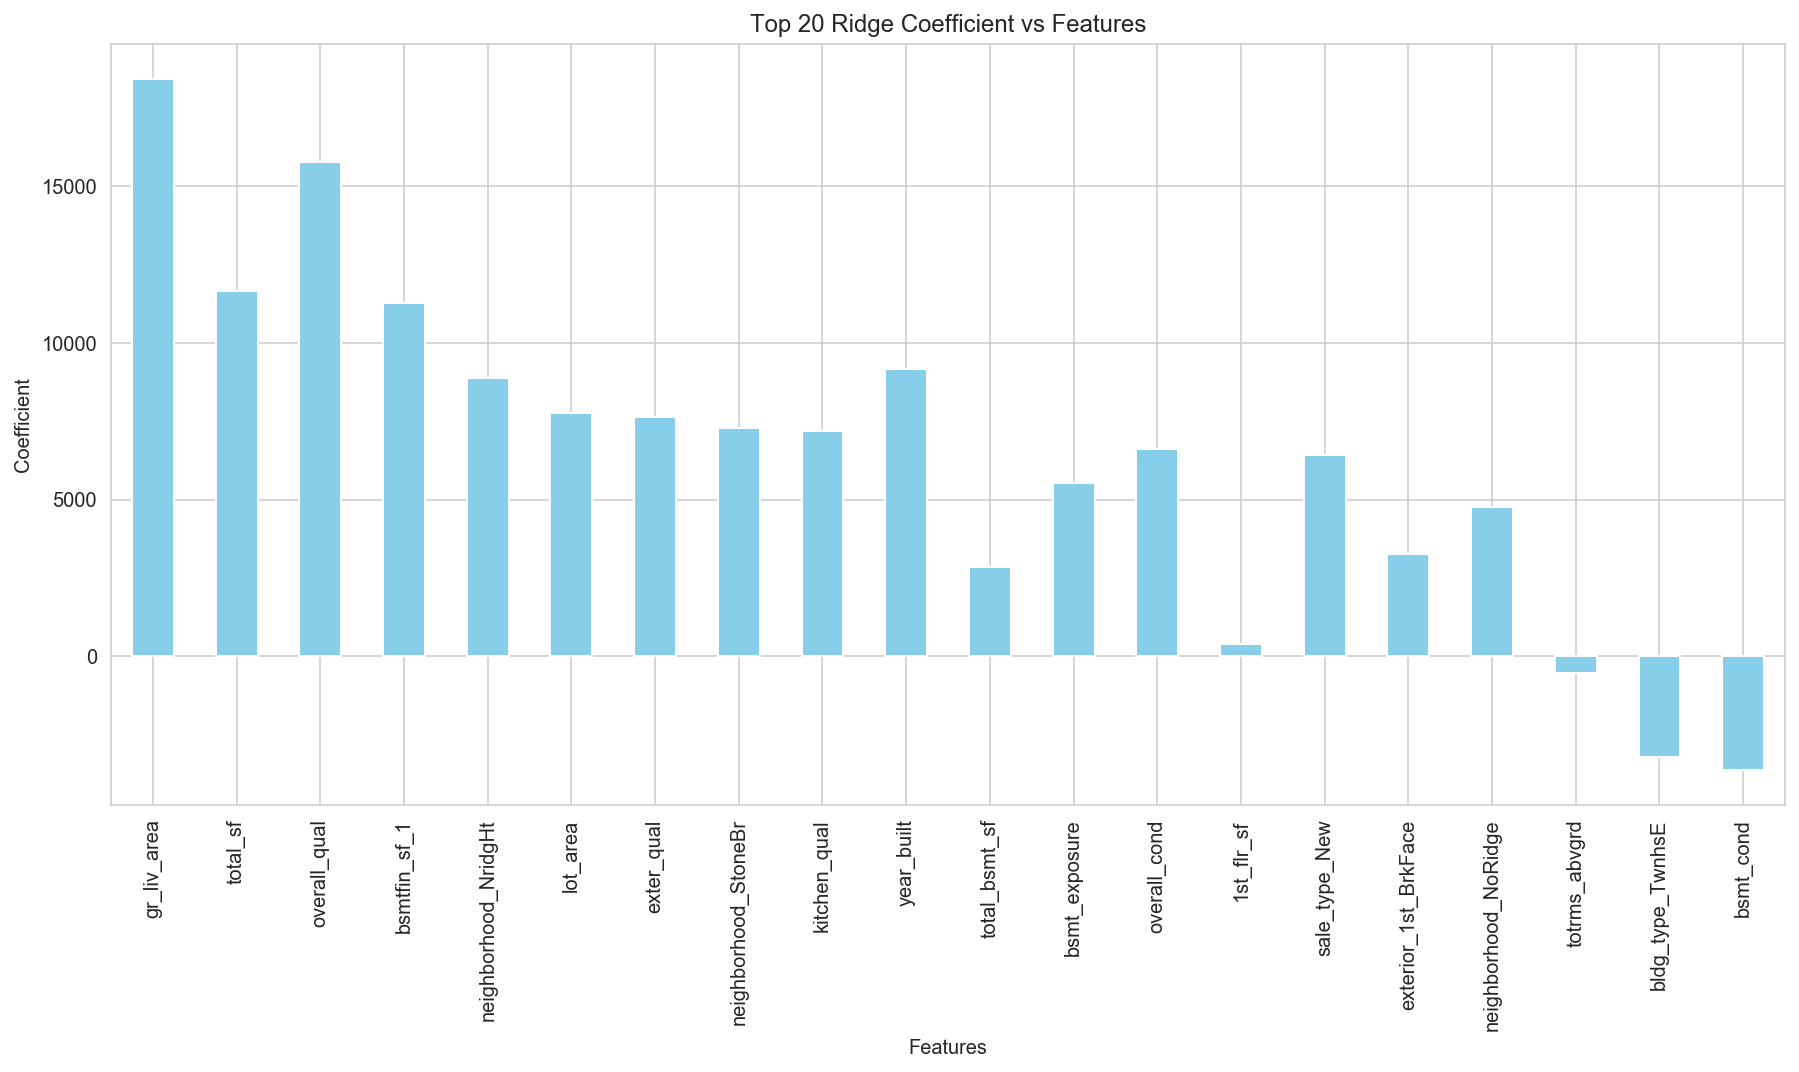

In [33]:
#visualising the coefficient
pd.Series(ridge2.coef_, index= feature_for_model2).plot.bar(figsize=(15,7),color='skyblue')
plt.title('Top 20 Ridge Coefficient vs Features')
plt.xlabel('Features')
plt.ylabel('Coefficient');

>This is a visualisation of Ridge coefficient. For every unit of increase/ decrease of the respective features, the corresponding y represents the amount of unit which we will see in increase and decrease in. For e.g. total_sf. For every increase in unit for total_sf, we will see approximately 12000 unit of increment sigificant level to sale price. 

In [34]:
print('---Ridge Remodel---')
print_metrics(y_test2,pred_ridge2,X.shape[1])

---Ridge Remodel---
Root mean squared error =  28234.978971784512
R^2                     =  0.8667139402621421
Adjusted R^2            =  0.7629826155096353


***Between both model comparison, I have picked the model with higher Adjusted R2 and lower RSME which is Ridge Regression for my final modelling.***

In [35]:
# try ridge for kaggle submission
# validate with validation test data for kaggle submission
X_sub=train[feature_for_model2]
y_sub=train['saleprice']

X_train3,X_test3,y_train3,y_test3=train_test_split(X_sub,y_sub,test_size=0.2,random_state=50)
print(X_train3.shape,X_test3.shape,y_train3.shape,y_test3.shape)


(1637, 20) (410, 20) (1637,) (410,)


In [36]:
ss=StandardScaler()
X_train3_scaled=ss.fit_transform(X_train3)
X_test3_scaled=ss.transform(test[feature_for_model2])

In [37]:
ridge_search=RidgeCV(alphas=np.logspace(0,5,200),store_cv_values=True)
ridge_search.fit(X_train3_scaled,y_train3)
ridge_sub=Ridge(alpha=ridge_search.alpha_)

In [38]:
score=cross_val_score(ridge_sub,X_train3_scaled,y_train3,cv=10)
ridge_sub.fit(X_train3_scaled,y_train3)
ridge_sub_prediction=ridge_sub.predict(X_test3_scaled)


#### Exporting results into CSV

In [39]:
sub_df(ridge_sub_prediction,'../datasets/ridge_sub_new_featured.csv')

## Modelling Visualisation and Results

### Initial

| Model              | Adjusted R2 | RMSE  |
| ------------------ | ----------- | :---: |
| Linear Regression  | -1.3        |   -   |
| Lasso (L1 Penalty) | 0.791       | 26453 |
| Ridge (L2 Penalty) | 0.796       | 26144 |
|                    |             |       |

### After modelling

| Model              | Adjusted R2 | RMSE  |
| ------------------ | ----------- | :---: |
| Lasso (L1 Penalty) | 0.791       | 29000 |
| Ridge (L2 Penalty) | 0.7629      | 28234 |

Since the adjusted R2 for Linear regression is negative, it shows us that the model is overfitted. Based on comparison between Ridge and Lasso, I have picked  Ridge Regression model which has a higher adjusted R2 and lower RMSE. I have performed filtering of top 20 features based on instructor requirement to re train our model and test the model with Kaggle.

#### Kaggle Submission Results with Ridge Regression

![Submission](../image/ridge_score_after_featured.png)


We would like to look at the features and various metrics of the model.

In [40]:
df_ridge_coeff_print=df_ridge_coeff.sort_values('coefficient',ascending=False)
df_ridge_coeff_print

,features,coefficient,abs_coefficient
22,gr_liv_area,12238.820523,12238.820523
32,total_sf,10430.062498,10430.062498
4,overall_qual,9883.549132,9883.549132
14,bsmtfin_sf_1,7365.789647,7365.789647
82,neighborhood_NridgHt,7142.794793,7142.794793
...,...,...,...
17,bsmt_unf_sf,-2786.237432,2786.237432
104,bldg_type_Twnhs,-2832.034956,2832.034956
23,bedroom_abvgr,-3237.253071,3237.253071
11,bsmt_cond,-3395.844533,3395.844533


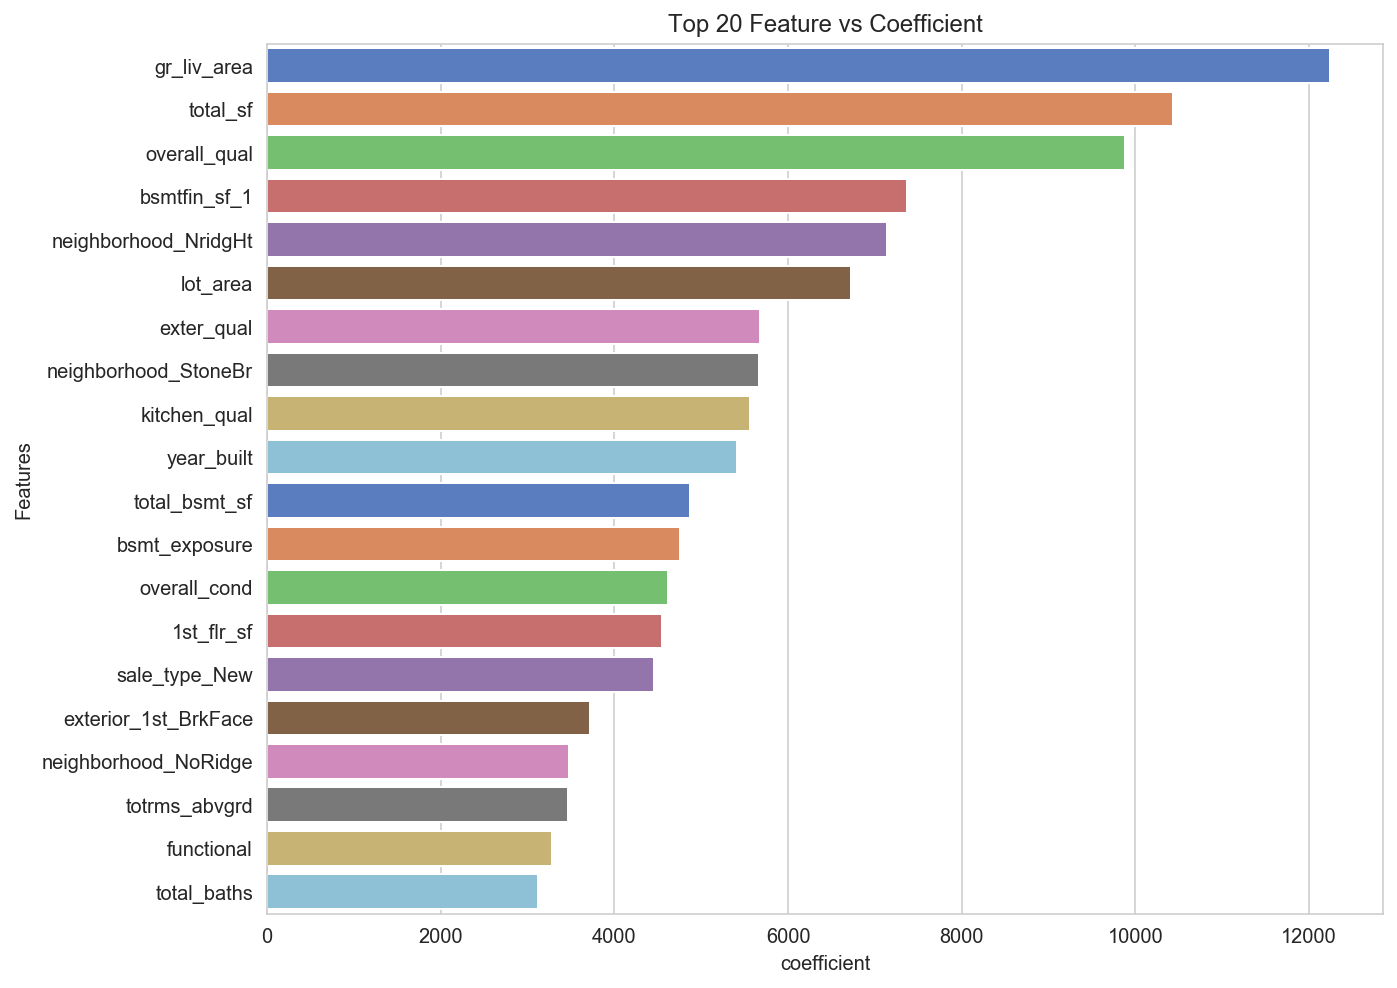

In [41]:
plt.figure(figsize=(10,8))
sns.barplot(x='coefficient',y='features',data=df_ridge_coeff_print[:20],palette="muted")
plt.title("Top 20 Feature vs Coefficient")
plt.ylabel('Features')
plt.savefig('../image/top20coefficient.png');

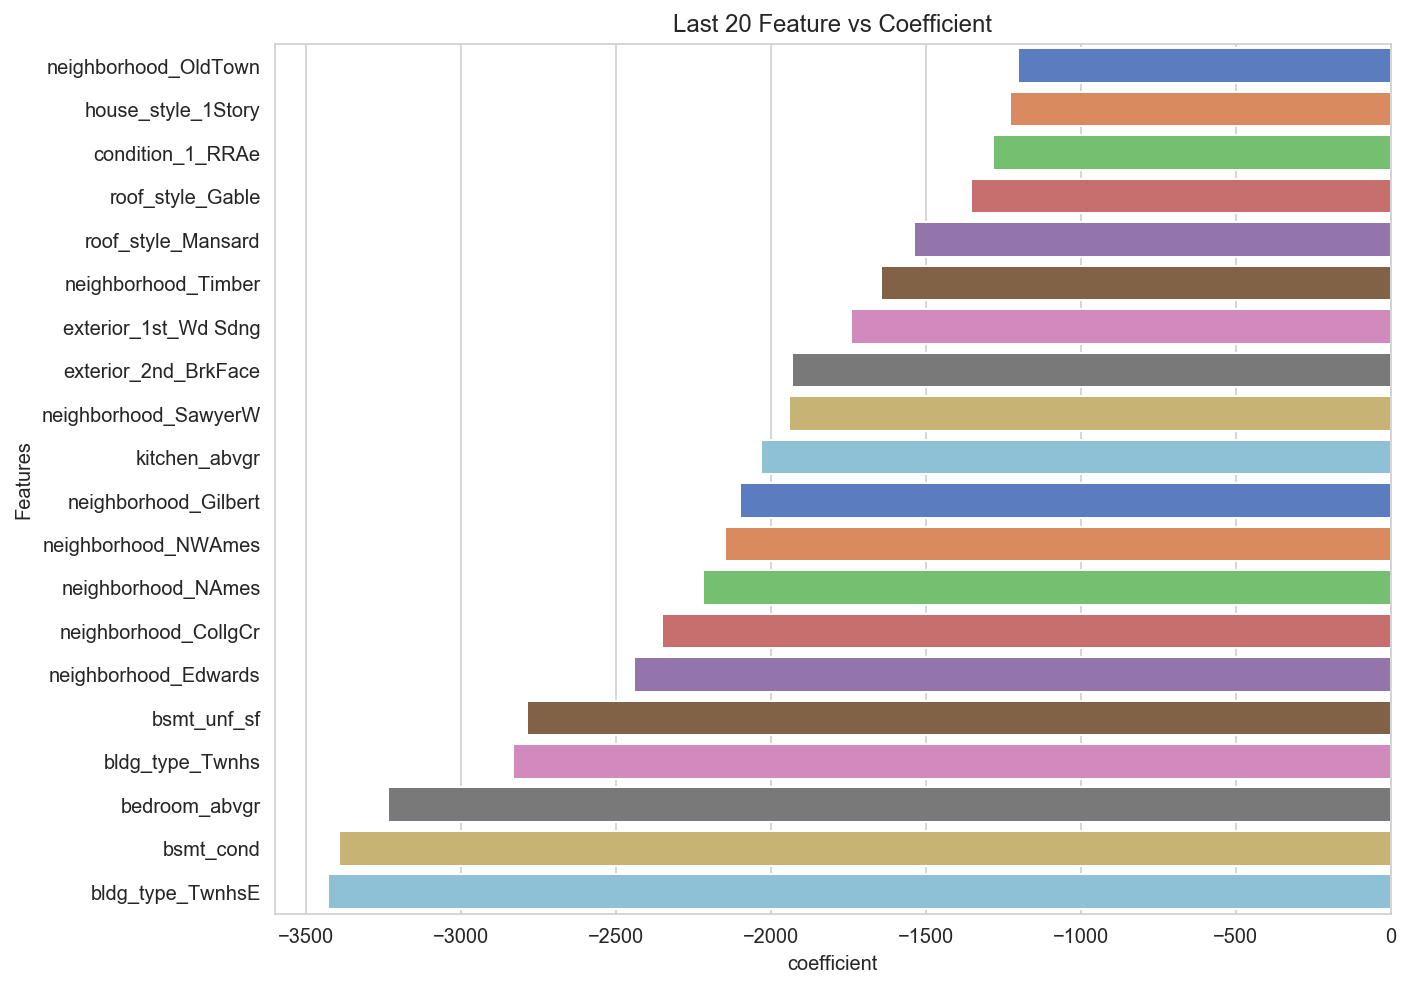

In [42]:
plt.figure(figsize=(10,8))
sns.barplot(x='coefficient',y='features',data=df_ridge_coeff_print[-20:],palette="muted")
plt.title("Last 20 Feature vs Coefficient")
plt.ylabel('Features')
plt.savefig('../image/last20coefficient.png');

# Conclusion and Recommendation

We developed a  model of Ames real estate prices, with R2= 0.762 and RMSE of about $28234 on out-of-sample data. This model is a great first step to help ACME identify opportunities for investment.

**Which feature appear to valueable feature to have?**


- Total surface area. Base on analysis, we would expect for every unit of increaes in square foot, it will have an average increment of approximately 12000 unit in value to home.
- It is important to also note that houses in neighborhood of  Northridge Heights will be expected to see a better valuation to the house.
- Additionally, the overall quality rating of the material and finish of a house - a 1 unit increase in the quality rating will increase the value to a home by around 10000 unit


**Which feature appear to be of least value to a home?**

- Townhouses are least favourable features among homebuyers.
- Houses in the neighborhood Edwards, College Creek,North Ames are least favorable to see better returns in housing. 

**Which of the neighborhood might be a good potential for investment**

![Neighbour](../image/neighborhood.png)


- As discussed earlier, our model have also validated that houses in neighborhood Northridge Heights and Stone Brook would expect better returns in housing. 
- This neighborhood are located around Ada Hayden park which consist of two lakes and wet lands. This could value add to the sale price of the properties as leisure activities for families in the vincity. 
- If the client is looking for investment purpose, these are the neighborhoods which they could be look into.

![Screenshot of neighborhood amenities of Northridge](../image/Northridge.jpg)

***Recommendations for buyers***

- New home owner
   - Get a house of newer tenure
   - Maximising surface area of house (e.g. building mezzanine to increase surface area)
   - Look into Stone Brook or NorthRidge
- Exisiting home owner
   - Perform maintenance work to upkeep average condition
   - Upgrading finishing work to improve housing quality
   

**What other improvement could be done on the model?**

- I have noted that the saleprice is postively skewed. We could evaluate the model after log the sale price of training set. 
- We could also look into polynominal features and evuluate if increasing degree of freedom helps.
- We explore other feature selection method (e.g. Wrapper method using Recursive Features Elimination or Embededd method)
- Filter method is less accurate. It is great while doing EDA, it can also be used for checking multi co-linearity in data.Wrapper and Embedded methods give more accurate results but as they are computationally expensive, these method are suited when you have lesser features
- I believe to generalise the model, since neighbourhood is too specific, we may look into colleting data for amenities, crime rates. 